In [55]:
%matplotlib inline
import numpy as np
from scipy.integrate import quad
import scipy.integrate
from scipy import optimize
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import gradients as gr
import dask
import sh
import os.path
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['contour.negative_linestyle']= 'dashed'
plt.rcParams['image.cmap'] = 'RdBu'

from progress_bar import *
from useful import *
from plotting import *

global data_dir
data_dir = '/scratch/ap587/dry_data/'

#plot_dir = '/scratch/ap587/plots/paper1/'
#mkdir = sh.mkdir.bake('-p')
#mkdir(plot_dir)

In [106]:
def overlay_field(ds, ax):
    '''contour overlay the specified data array on the argument axis
    Only works for lat-pfull plots so far'''
    x, y = np.meshgrid(ds.lat.values, ds.pfull.values)
    ax.contour(x, y, ds, 8, add_colorbar=False, robust=True, colors='k', alpha=0.5)

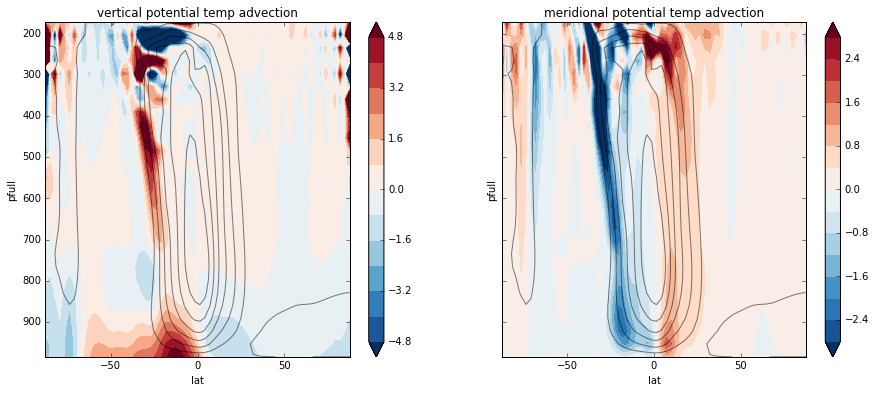

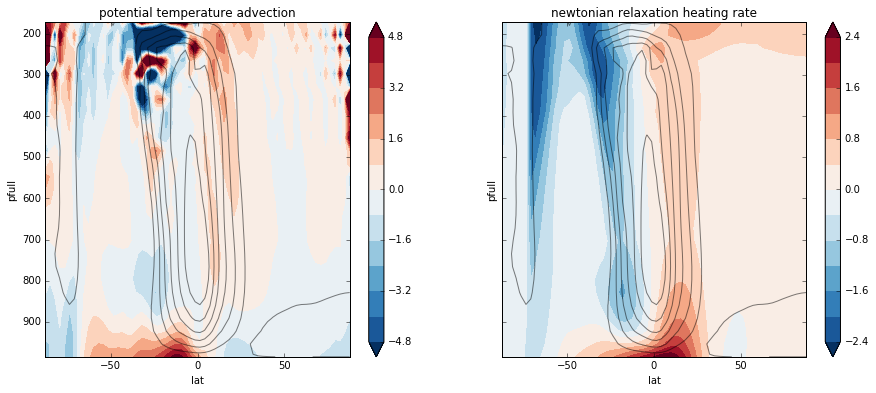

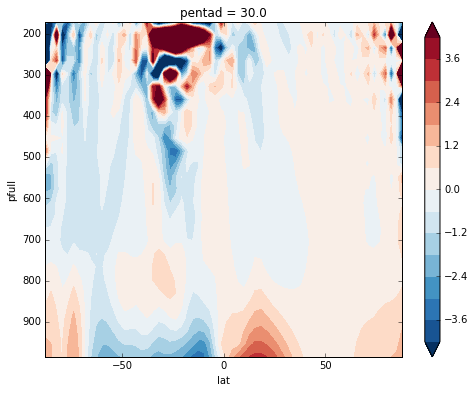

In [143]:
# proper look at thermodynamics - seasonal
# test year fractions:
summer = 30
equinox = 48

obl = 30
exp = 'exp9v1_hc10.0-obl{:.1f}'.format(obl)
yl = 360
ds = open_climatology(data_dir, exp)
ds = ds.isel(pfull=slice(5, None))
#ds = ds.mean('pentad')
ds = ds.isel(pentad=summer)

if not 'ptemp' in ds.keys():
    ds = calc_pot_temp(ds)
#advection terms in thermodynamic equation
ptemp_dx = gr.ddy(ds.ptemp)
ptemp_dp = gr.ddp(ds.ptemp)
mer_adv = ds.vcomp*ptemp_dx*86400     # make these change per day
ver_adv = ds.omega*ptemp_dp*86400
sum_adv = mer_adv+ver_adv

# change in pot_temp due to newtonian heating
ka = 1/20
ks = 1/5
sigb = 0.7
pscale = (ds.pfull*100/ds.ps-sigb)/(1-sigb)
pd = pscale.values
pd[pd<0] = 0
pscale.data = pd
kt = ka + (ks-ka)*pscale*np.cos(np.deg2rad(ds.lat))**4
ptemp_dt = -kt*(ds.ptemp - ds.teq*(ds.ps/100/ds.pfull)**0.286)
#

#
fig, axes = plt.subplots(1,2, figsize=(15,6), sharey=True)
mer_adv.plot.contourf(x='lat', y='pfull',levels=15, ax=axes[0], robust=True)
ver_adv.plot.contourf(x='lat', y='pfull',levels=15, ax=axes[1], robust=True)
overlay_field(ds.psi, axes[0])
overlay_field(ds.psi, axes[1])
axes[0].invert_yaxis()
axes[0].set_title('vertical potential temp advection')
axes[1].set_title('meridional potential temp advection')

#
fig, axes = plt.subplots(1,2, figsize=(15,6), sharey=True)
sum_adv.plot.contourf(x='lat', y='pfull',levels=15, ax=axes[0], robust=True)
ptemp_dt.plot.contourf(x='lat', y='pfull',levels=15, ax=axes[1], robust=True)
overlay_field(ds.psi, axes[0])
overlay_field(ds.psi, axes[1])
axes[0].invert_yaxis()
axes[0].set_title('potential temperature advection')
axes[1].set_title('newtonian relaxation heating rate')

#
fig, ax = plt.subplots()
(ptemp_dt - sum_adv).plot.contourf(x='lat', y='pfull',levels=15, robust=True)
ax.invert_yaxis()

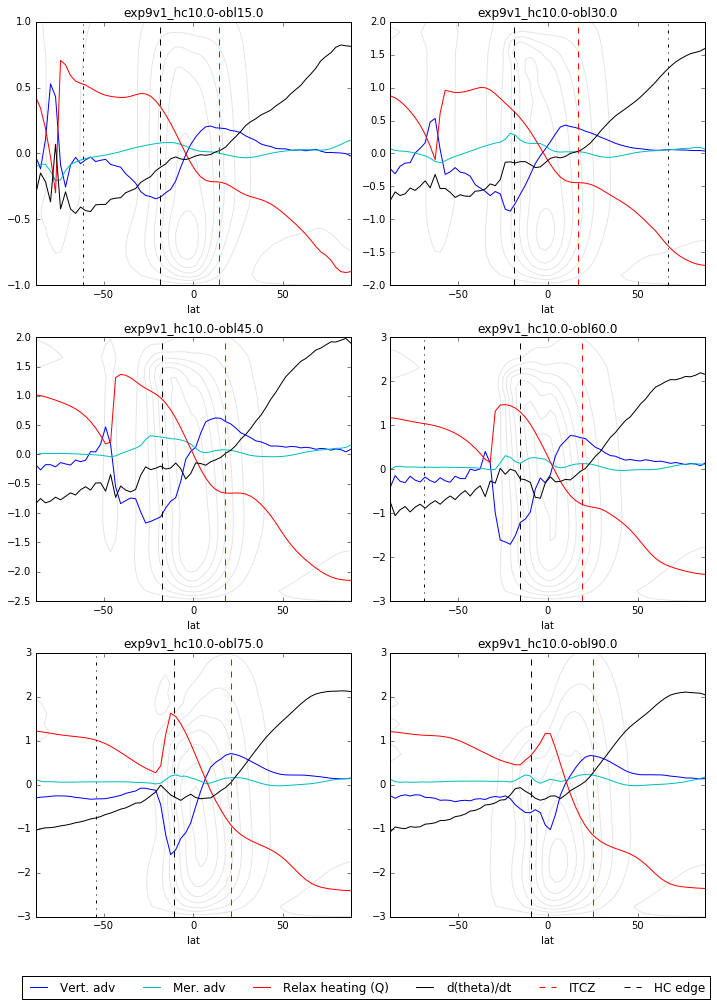

In [276]:
# proper look at thermodynamics - seasonal column average
# test year fractions:
# insolation field points: eq1 - 0, nh_sol - 18, eq2 - 36, sh_sol - 54
# plus 9 from postprocessing...
data_dir = '/scratch/ap587/dry_data/'
plot_dir = '/scratch/ap587/plots/thermo/'
mkdir = sh.mkdir.bake('-p')
mkdir(plot_dir)

am = slice(0,None)
sol = np.arange(16,21)   #slice(16, 21)
eq = np.arange(34,39)  #slice(34, 39)
# old plot season selctions - goes off temp instead of insolation
#sol = slice(27,34)
#eq = np.hstack(([45, 46, 47, 48, 49, 50, 51], np.arange(9,16)))

rdgas = 287.04
kappa = 2/7
cp = rdgas/kappa

obls = np.arange(15,91,15)
fig, axes = plt.subplots(len(obls)//2, 2, figsize=(10,14))

for i, obl in enumerate(obls):
    exp = 'exp9v1_hc10.0-obl{:.1f}'.format(obl)
    ds = open_climatology(data_dir, exp)
    ds = ds.isel(pfull=slice(5, None))
    ###
    ds = ds.isel(pentad=sol).mean('pentad')
    ###
    if not 'ptemp' in ds.keys():
        ds = calc_pot_temp(ds)
    #advection terms in thermodynamic equation
    ptemp_dx = gr.ddy(ds.ptemp)
    ptemp_dp = gr.ddp(ds.ptemp)
    mer_adv = (ds.vcomp*ptemp_dx*86400).mean('pfull')     # make these change per day
    ver_adv = (ds.omega*ptemp_dp*86400).mean('pfull')
    sum_adv = mer_adv+ver_adv

    # change in pot_temp due to newtonian heating
    ka = 1/20
    ks = 1/5
    sigb = 0.7
    pscale = (ds.pfull*100/ds.ps-sigb)/(1-sigb)
    pd = pscale.values
    pd[pd<0] = 0
    pscale.data = pd
    kt = ka + (ks-ka)*pscale*np.cos(np.deg2rad(ds.lat))**4
    ptemp_dt = -kt*(ds.ptemp - ds.teq*(ds.ps/100/ds.pfull)**(rdgas/cp))
    ptemp_dt = ptemp_dt.mean('pfull')
    #
    itcz = calc_itcz_lat(ds)
    hedge1 = calc_descending_branch(ds)
    hedge2 = calc_descending_branch(ds, n=1)
    
    ax=axes[i//2, i%2]
    ver_adv.plot(label='Vert. adv', ls='-', color='b', ax=ax)
    mer_adv.plot(label='Mer. adv', ls='-', color='c', ax=ax)
    (-ptemp_dt).plot(label='Relax heating (Q)', ls='-', color='r', ax=ax)
    (ptemp_dt-sum_adv).plot(label='d(theta)/dt', color='k', ax=ax)   
    #(ver_adv+mer_adv-ptemp_dt+ptemp_dt-sum_adv).plot(ax=ax)
    #overlay overturning circulation
    x, y = np.meshgrid(ds.lat.values, np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], len(ds.pfull.values)))
    ax.contour(x, y[::-1], ds.psi, 8, add_colorbar=False, robust=True, colors='k', alpha=0.1)
    #
    ax.axvline(itcz, color='r', ls='--', label='ITCZ')
    ax.axvline(hedge1, color='k', ls='--', label='HC edge')
    ax.axvline(hedge2, color='k', ls='-.')
    ax.set_title(exp)
plt.tight_layout(rect=[0,0.05,1,1])
plt.legend(bbox_to_anchor=(1,0), loc='lower right', bbox_transform=fig.transFigure, ncol=6)

savename = 'exp9v1_sol_mean_thermo'
plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)


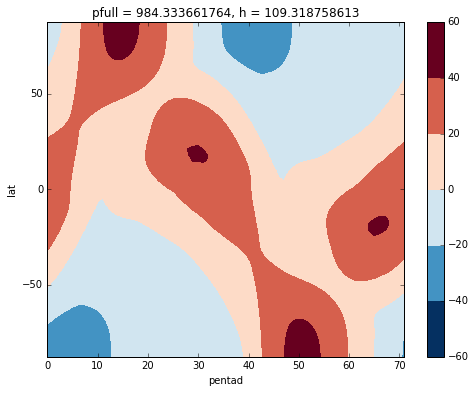

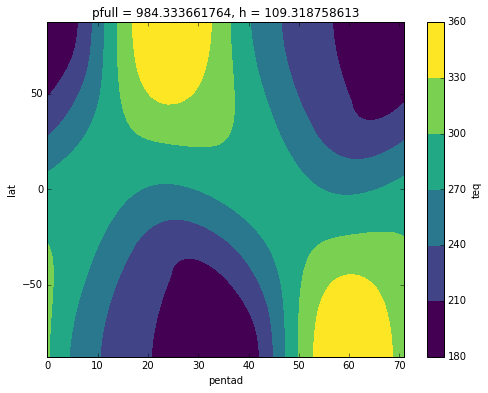

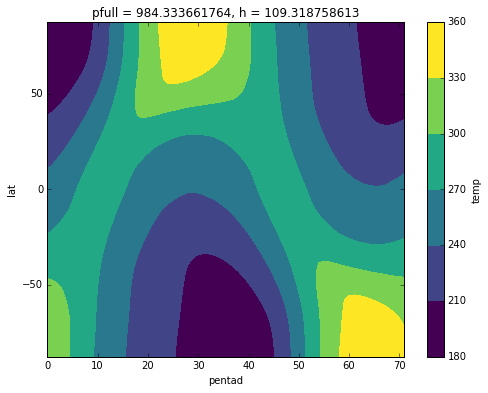

In [277]:
# comparison of temperature fields to feel out seasons
obl = 60
exp = 'exp9v1_hc10.0-obl{:.1f}'.format(obl)
ds = open_climatology(data_dir, exp)

(ds.teq-ds.temp).isel(pfull=-1).plot.contourf(x='pentad', y='lat')
plt.subplots()
ds.teq.isel(pfull=-1).plot.contourf(x='pentad', y='lat')
plt.subplots()
ds.temp.isel(pfull=-1).plot.contourf(x='pentad', y='lat')

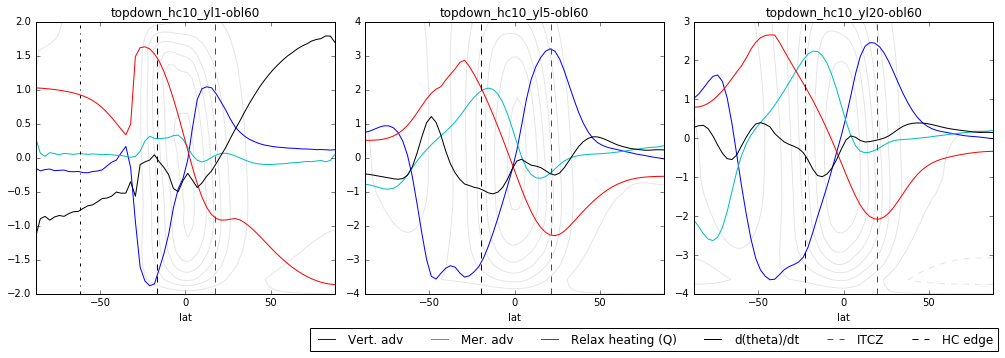

In [298]:
# thermodynamic analysis of long year run
data_dir = '/scratch/ap587/gfdl_data/'
yls = [1,5,20]

am = slice(0,None)
sol = (np.arange(64,69)+5)%72  #slice(16, 21)
eq = (sol + 18)%72    #slice(34, 39)

rdgas = 287.04
kappa = 2/7
cp = rdgas/kappa

fig, axes = plt.subplots(1,3, figsize=(14,5))
for i in range(len(yls)):
    exp = 'topdown_hc10_yl{}-obl60'.format(yls[i])
    ds = open_climatology(data_dir, exp)
    ds = ds.isel(pfull=slice(5, None))
    ###
    pentad_sel = sol
    if yls[i] == 1:
        pentad_sel = (pentad_sel+20)%72
    ds = ds.isel(pentad=pentad_sel).mean('pentad')
    ###
    if not 'ptemp' in ds.keys():
        ds = calc_pot_temp(ds)
    #advection terms in thermodynamic equation
    ptemp_dx = gr.ddy(ds.ptemp)
    ptemp_dp = gr.ddp(ds.ptemp)
    mer_adv = (ds.vcomp*ptemp_dx*86400).mean('pfull')     # make these change per day
    ver_adv = (ds.omega*ptemp_dp*86400).mean('pfull')
    sum_adv = mer_adv+ver_adv

    # change in pot_temp due to newtonian heating
    ka = 1/20
    ks = 1/5
    sigb = 0.7
    pscale = (ds.pfull*100/ds.ps-sigb)/(1-sigb)
    pd = pscale.values
    pd[pd<0] = 0
    pscale.data = pd
    kt = ka + (ks-ka)*pscale*np.cos(np.deg2rad(ds.lat))**4
    ptemp_dt = -kt*(ds.ptemp - ds.teq*(ds.ps/100/ds.pfull)**(rdgas/cp))
    ptemp_dt = ptemp_dt.mean('pfull')
    #
    itcz = calc_itcz_lat(ds)
    hedge1 = calc_descending_branch(ds)
    hedge2 = calc_descending_branch(ds, n=1)
    
    ax=axes[i]
    ver_adv.plot(label='Vert. adv', ls='-', color='b', ax=ax)
    mer_adv.plot(label='Mer. adv', ls='-', color='c', ax=ax)
    (-ptemp_dt).plot(label='Relax heating (Q)', ls='-', color='r', ax=ax)
    (ptemp_dt-sum_adv).plot(label='d(theta)/dt', color='k', ax=ax)   
    #(ver_adv+mer_adv-ptemp_dt+ptemp_dt-sum_adv).plot(ax=ax)
    #overlay overturning circulation
    x, y = np.meshgrid(ds.lat.values, np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], len(ds.pfull.values)))
    ax.contour(x, y[::-1], ds.psi, 8, add_colorbar=False, robust=True, colors='k', alpha=0.1)
    #
    ax.axvline(itcz, color='r', ls='--', label='ITCZ')
    ax.axvline(hedge1, color='k', ls='--', label='HC edge')
    ax.axvline(hedge2, color='k', ls='-.')
    ax.set_title(exp)
plt.tight_layout(rect=[0,0.07,1,1])
plt.legend(bbox_to_anchor=(1,0), loc='lower right', bbox_transform=fig.transFigure, ncol=6)

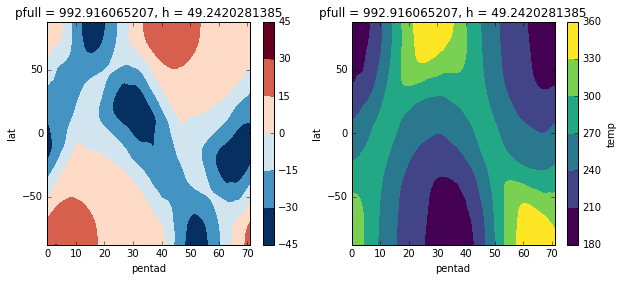

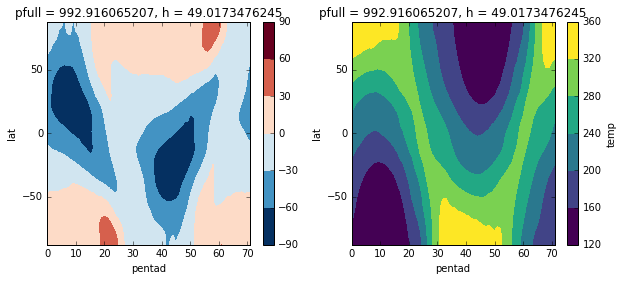

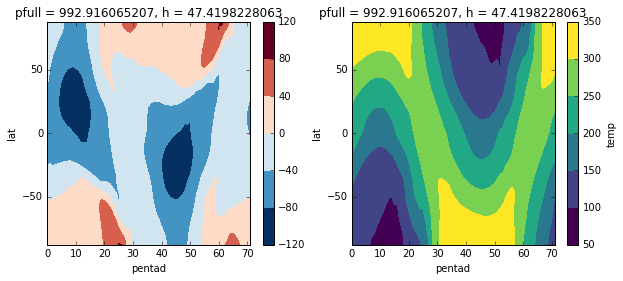

In [314]:
data_dir = '/scratch/ap587/gfdl_data/'
yls = [1,5,20]
for yl in yls:
    exp = 'topdown_hc10_yl{}-obl60'.format(yl)
    ds = open_climatology(data_dir, exp)
    #if yl == 1:
    #    ds = ds.roll(pentad=20)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    (ds.temp-ds.teq).isel(pfull=-1).plot.contourf(x='pentad', ax=axes[0])
    ds.temp.isel(pfull=-1).plot.contourf(x='pentad', ax=axes[1])

In [224]:
ds.temp.mean('pfull').mean('lat').values
ds.ptemp.mean('pfull').mean('lat').values

array(307.69716672139566)

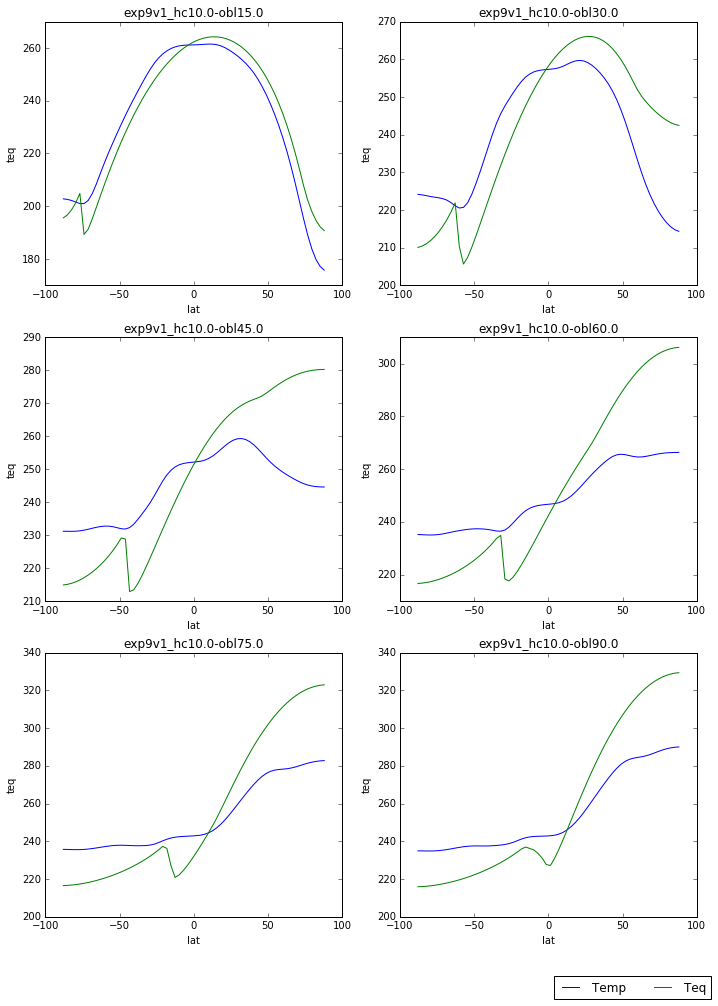

In [257]:
# seasonal temperature plots
plot_dir = '/scratch/ap587/plots/thermo/'
mkdir = sh.mkdir.bake('-p')
mkdir(plot_dir)

#am = slice(0,None)
#sol = slice(27,34)
#eq = np.hstack(([45, 46, 47, 48, 49, 50, 51], np.arange(9,16)))

obls = np.arange(15,91,15)
fig, axes = plt.subplots(len(obls)//2, 2, figsize=(10,14))

for i, obl in enumerate(obls):
    exp = 'exp9v1_hc10.0-obl{:.1f}'.format(obl)
    ds = open_climatology(data_dir, exp)
    ds = ds.isel(pfull=slice(5, None))
    ###
    ds = ds.isel(pentad=sol).mean('pentad')
    ###    
    ax=axes[i//2, i%2]
    ds.temp.mean('pfull').plot(label='Temp', ax=ax)
    ds.teq.mean('pfull').plot(label='Teq', ax=ax)
    ax.set_title(exp)
plt.tight_layout(rect=[0,0.05,1,1])
plt.legend(bbox_to_anchor=(1,0), loc='lower right', bbox_transform=fig.transFigure, ncol=6)

savename = 'exp9v1_sol_mean_temps'
#plt.savefig(plot_dir + savename + '.png', dpi=200,bbox_inches='tight',transparent=False)
#plt.savefig(plot_dir + savename + '.pdf', dpi=200,bbox_inches='tight',transparent=False)



In [76]:
ka = 1/20
ks = 1/5
sigb = 0.7
pscale = (ds.pfull*100/ds.ps-sigb)/(1-sigb)
pd = pscale.values
pd[pd<0] = 0
pscale.data = pd
kt = ka + (ks-ka)*(ds.pfull*100/ds.ps-sigb)/(1-sigb)*np.cos(np.deg2rad(ds.lat))**4
ptemp_dt = kt*(ds.ptemp - ds.teq*(ds.ps/100/ds.pfull)**0.286)

print(pscale)

<xarray.DataArray (pfull: 32, lat: 64)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ..., 
       [ 0.564005,  0.564212,  0.564385, ...,  1.073118,  1.073901,  1.0743  ],
       [ 0.662229,  0.662443,  0.662622, ...,  1.188602,  1.189411,  1.189824],
       [ 0.760453,  0.760674,  0.760859, ...,  1.304085,  1.304921,  1.305348]])
Coordinates:
  * pfull    (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 234.2 ...
    pentad   float64 30.0
    h        (pfull) float64 dask.array<shape=(32,), chunksize=(32,)>
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...


In [56]:
ds

<xarray.Dataset>
Dimensions:      (lat: 64, latb: 65, lonb: 129, pentad: 72, pfull: 32, phalf: 33)
Coordinates:
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * phalf        (phalf) float64 0.0 31.25 62.5 93.75 125.0 156.2 187.5 ...
  * pfull        (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 ...
  * pentad       (pentad) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
    h            (pfull) float64 dask.array<shape=(32,), chunksize=(32,)>
Data variables:
    ps           (pentad, lat) float64 dask.array<shape=(72, 64), chunksize=(72, 64)>
    bk           (pentad, phalf) float64 dask.array<shape=(72, 33), chunksize=(72, 33)>
    ucomp        (pentad, pfull, lat) float64 dask.array<shape=(72, 32, 64), chunksize=(72, 32, 64)>
    vcomp        (pentad, pfull, lat) float64 dask.array<sha

In [25]:
#ds = open_runset('/scratch/ap587/gfdl_data/', 'frierson_hc10-obl15', ncfile='atmos_daily.nc')
#ds = ds.isel(time=slice(-3*yl, None))
np.floor((ds.time.values[0:30]/24 -1)%360/(yl/72))

array([ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,
        2.,  2.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  5.,
        5.,  5.,  5.,  5.])

In [13]:

ds

<xarray.Dataset>
Dimensions:      (lat: 64, latb: 65, lon: 128, lonb: 129, pfull: 32, phalf: 33, time: 1080)
Coordinates:
  * lon          (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * phalf        (phalf) float64 0.0 31.25 62.5 93.75 125.0 156.2 187.5 ...
  * pfull        (pfull) float64 11.5 45.98 77.6 109.0 140.3 171.6 202.9 ...
  * time         (time) float64 1.73e+04 1.733e+04 1.735e+04 1.738e+04 ...
    day          (time) float64 23.0 47.0 71.0 95.0 119.0 143.0 167.0 191.0 ...
    day0         (time) float64 32.0 56.0 80.0 104.0 128.0 152.0 176.0 200.0 ...
    season       (time) float64 0.0 0.0 0.0 1.0 1.0 1.0 1.0 2.0 2.0 2.0 3.0 ...
    pentad       (time) float64 6.0 11.0 16.0 20.0 25.0 30.0 35.0 40.0 44.0 ...
Data variables:


In [30]:
rdgas  = 287.04
kappa  = 2./7.
cp = rdgas/kappa
g0 = 9.81     
# geopotential = gph*g0

exp = 'exp9v2_hc10.0-obl15.0'
ds = open_climatology(data_dir, exp)

iet = cp*ds.temp
ieg = g0*ds.height
integrand_sig = ds.vcomp*(cp*ds.temp + ds.height*g0) * ds.pfull.diff('pfull')/(ds.pfull*100/ds.ps).diff('pfull')
integrand = ds.vcomp*(iet+ieg)
dTE = np.zeros(ds.lat.size)

integrand = integrand.mean('pentad')
for i in range(ds.lat.size):
    dTE[i] = scipy.integrate.trapz(integrand.isel(lat=i), x=ds.pfull)/g0

-215520.281976


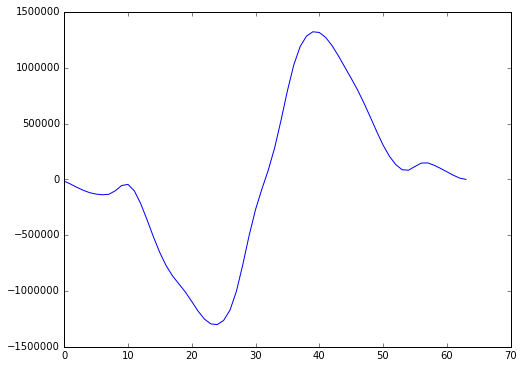

In [45]:
plt.plot(dTE)
print(sum(dTE))

In [37]:
# heat transport
ka = 1/20
ks = 1/5
sigb = 0.7

exp = 'exp9v1_hc10.0-obl15.0'
ds = open_climatology(data_dir, exp)

ds = calc_pot_temp(ds)
dss = ds.mean('pentad')
hflux = (ds.vcomp*ds.pot_temp).mean('pentad')
meanflux = dss.vcomp*dss.pot_temp
eddyflux = hflux - meanflux

# flux due to newtonian heating = sum(pentad/k_t * teq-temp)
kt = ka + (ks-ka)*(ds.pfull*100/ds.ps-sigb)/(1-sigb)*np.cos(ds.lat)**4
kt = kt/84600

hedge1 = calc_descending_branch(dss)
hedge2 = calc_descending_branch(dss, n=1)


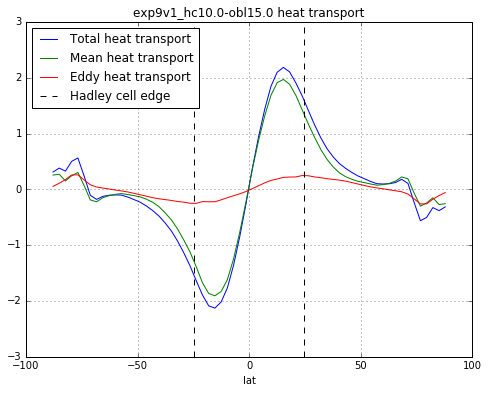

In [38]:
fig, ax = plt.subplots()
hflux.mean('pfull').plot(label='Total heat transport')
meanflux.mean('pfull').plot(label='Mean heat transport')
eddyflux.mean('pfull').plot(label='Eddy heat transport')
ax.axvline(hedge1, ls='--', color='k', label='Hadley cell edge')
ax.axvline(hedge2, ls='--', color='k')
plt.legend(loc=2)
plt.grid()
ax.set_title('{} heat transport'.format(exp))

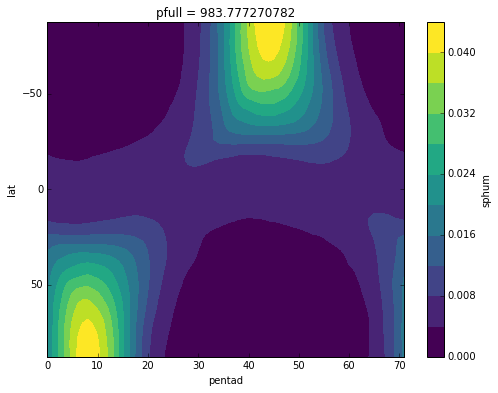

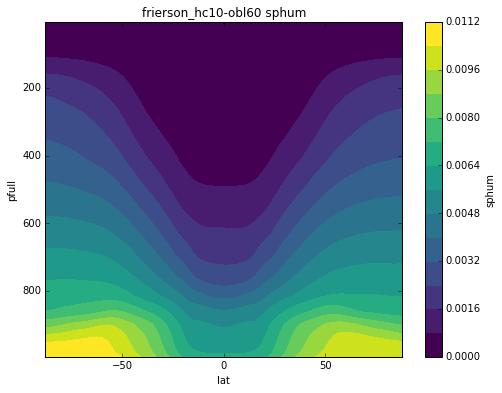

In [29]:
exp = 'frierson_hc10-obl{}'.format(60)
ds = open_climatology('/scratch/ap587/gfdl_data/', exp)

ds.sphum.isel(pfull=-2).plot.contourf(x='pentad', y='lat', levels=15)
plt.gca().invert_yaxis()

fig, ax = plt.subplots()
ds.sphum.mean('pentad').plot.contourf(x='lat', y='pfull', levels=15)
plt.gca().invert_yaxis()
ax.set_title(exp + ' sphum')

In [21]:
ds = open_runset('/scratch/ap587/gfdl_data/', 'bog_ruthparams_hc10-obl{}'.format(60), runs=range(0, 50), ncfile='atmos_daily.nc')

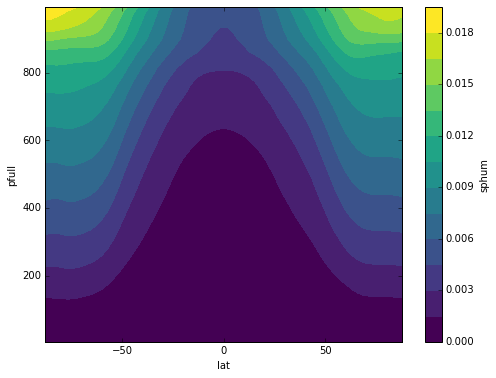

In [22]:
ds.sphum.isel(time=slice(-360,None)).mean('time').mean('lon').plot.contourf(x='lat', y='pfull', levels=15)
plt.gca().invert_yaxis()

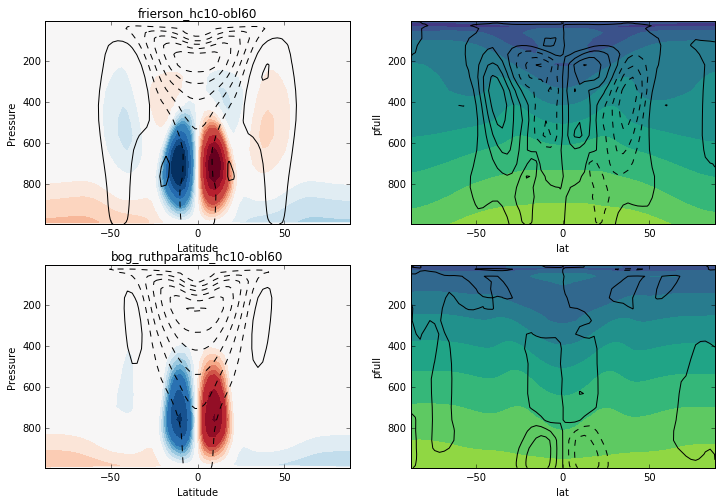

In [20]:
obl = 60

exps = ['frierson_hc10-obl{}'.format(obl), 'bog_ruthparams_hc10-obl{}'.format(obl)]

season = None
season_array = [np.arange(8,26), np.arange(26,44), np.arange(44,62), np.append(np.arange(0,8),np.arange(62,72))]
tlev = np.arange(180, 320, 10)
psilev = psilev = np.array([-15e10, -12e10, -9e10, -6e10,-5e10, -4e10, -3e10, -2e10, -1e10,
                                1e10, 2e10, 3e10, 4e10,5e10, 6e10, 9e10, 12e10, 15e10])
ulev = np.arange(-75, 76, 10)
    
fig, axes = plt.subplots(len(exps), 2, figsize=(12, 4*len(exps)))        
for i, exp in enumerate(exps):
    ds = open_climatology('/scratch/ap587/gfdl_data/', exp)
    if season == None:
        dss = ds.mean('pentad')
    else:
        dss = ds.isel(pentad=season_array[season]).mean('pentad')
            
    x = dss.lat.values
    y = dss.pfull.values    
    X, Y = np.meshgrid(x, y)
        
    axes[i,0].contour(X, Y, dss.ucomp, ulev, add_colorbar=False, robust=True, colors='k')
    dss.psi.plot.contourf(x='lat', y='pfull', ax=axes[i,0], add_colorbar=False, robust=True, levels=psilev)
    axes[i,0].invert_yaxis()
    axes[i,0].set_xlabel('Latitude')
    axes[i,0].set_ylabel('Pressure')
    axes[i,0].set_title(exp)
        
        
    dss.temp.plot.contourf(x='lat', y='pfull', ax=axes[i,1], add_colorbar=False, levels=tlev)
    axes[i,1].contour(X, Y, dss.uv, add_colorbar=False, robust=True,  colors='k')
    axes[i,1].invert_yaxis()

In [73]:
ds

<xarray.Dataset>
Dimensions:        (lat: 64, latb: 65, lon: 128, lonb: 129, nv: 2, pfull: 25, phalf: 26, time: 2880)
Coordinates:
  * lon            (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * lonb           (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 15.47 ...
  * lat            (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * latb           (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 -75.36 ...
  * nv             (nv) float64 1.0 2.0
  * phalf          (phalf) float64 0.0 11.77 19.67 31.52 48.54 71.93 102.8 ...
  * pfull          (pfull) float64 4.329 15.55 25.36 39.73 59.86 86.9 121.8 ...
  * time           (time) float64 12.0 36.0 60.0 84.0 108.0 132.0 156.0 ...
Data variables:
    ps             (time, lat, lon) float64 dask.array<shape=(2880, 64, 128), chunksize=(90, 64, 128)>
    bk             (time, phalf) float64 dask.array<shape=(2880, 26), chunksize=(90, 26)>
    pk             (time, phalf) float64 dask.array<shape=(2880, 26), 